#  **Predict Student Dropout and Academic Success**



## **Introdução e Objetivos**
O objetivo deste trabalho é desenvolver modelos de Aprendizado de Máquina capazes de prever a trajetória acadêmica de estudantes universitários. O problema é de **classificação**, onde buscamos enquadrar o aluno em uma das três categorias:
1.  **Dropout** (Desistente)
2.  **Enrolled** (Matriculado)
3.  **Graduate** (Graduado)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set_style("whitegrid")

df = pd.read_csv('data.csv', sep=',')

# Verificação inicial
print(f"Dimensões: {df.shape}")
print(f"Valores Nulos: {df.isnull().sum().sum()}") # Requisito: Tratar valores faltantes
display(df.head(3))

Dimensões: (4424, 35)
Valores Nulos: 0


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout


## **Análise Exploratória de Dados (EDA)**
Antes da modelagem, investigamos as características do dataset para identificar padrões e desbalanceamentos. Abaixo, analisamos a distribuição das classes e a relação entre o desempenho acadêmico (notas) e a evasão.


/tmp/ipython-input-927334965.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Target', data=df, palette='viridis')


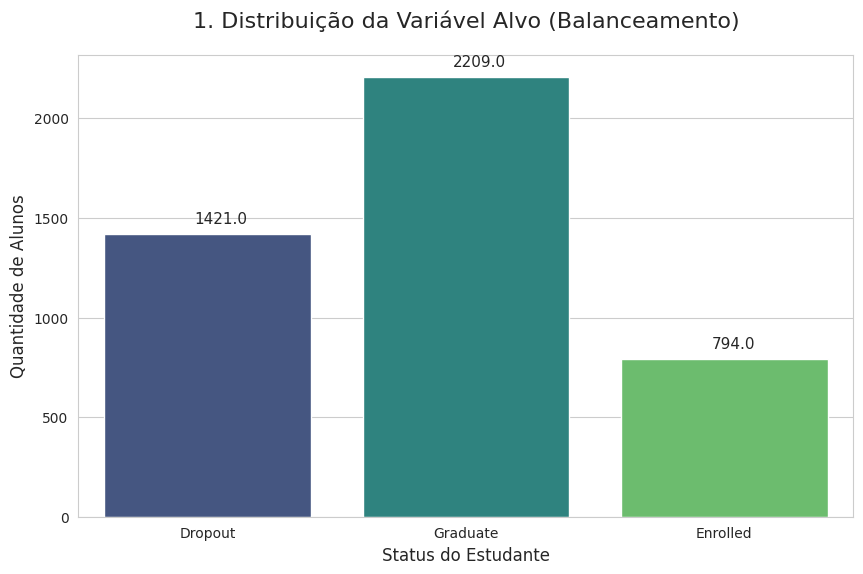

/tmp/ipython-input-927334965.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y='Curricular units 2nd sem (grade)', data=df, palette='Set2')


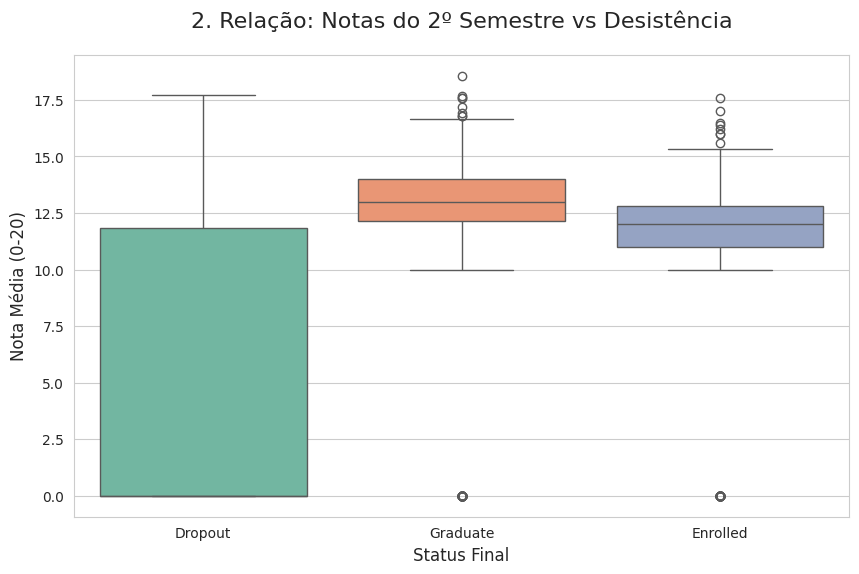

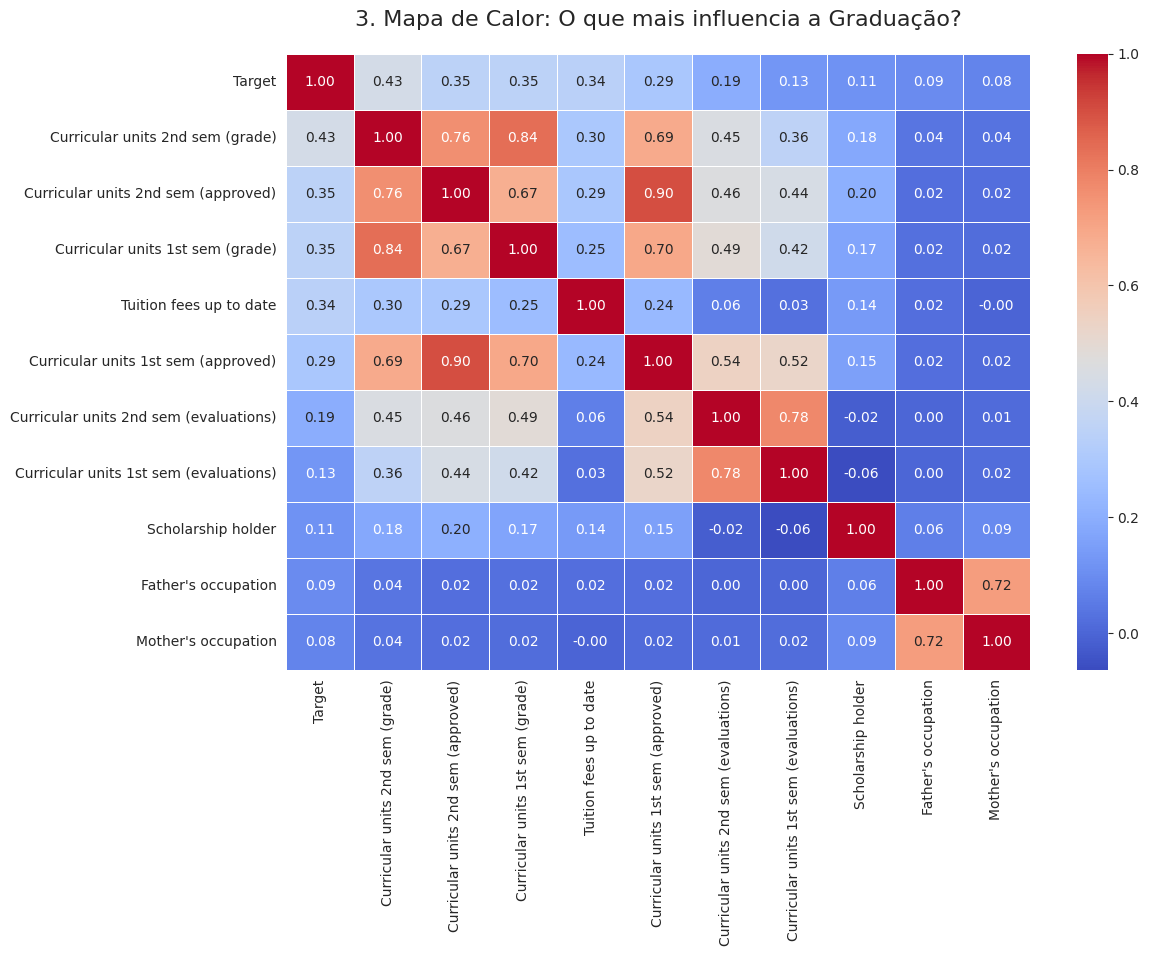

In [ ]:
# GRÁFICO 1: DISTRIBUIÇÃO DAS CLASSES
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Target', data=df, palette='viridis')

plt.title('1. Distribuição da Variável Alvo (Balanceamento)', fontsize=16, pad=20)
plt.xlabel('Status do Estudante', fontsize=12)
plt.ylabel('Quantidade de Alunos', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 50), fontsize=11)

plt.show()
print("\n" * 2) #apenas por estetica


#GRÁFICO 2: NOTAS VS STATUS
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Curricular units 2nd sem (grade)', data=df, palette='Set2')

plt.title('2. Relação: Notas do 2º Semestre vs Desistência', fontsize=16, pad=20)
plt.ylabel('Nota Média (0-20)', fontsize=12)
plt.xlabel('Status Final', fontsize=12)

plt.show()
print("\n" * 2) #apenas por estetica


# GRÁFICO 3: MATRIZ DE CORRELAÇÃ
plt.figure(figsize=(12, 8))

#  dados para correlação
df_temp = df.copy()
df_temp['Target'] = df_temp['Target'].factorize()[0]
# apenas as 10 variáveis mais importantes
cols_corr = df_temp.corr().nlargest(11, 'Target')['Target'].index

#  Heatmap
sns.heatmap(df_temp[cols_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

plt.title('3. Mapa de Calor: O que mais influencia a Graduação?', fontsize=16, pad=20)

plt.show()

### **Interpretação da Análise Exploratória:**
Com base nos gráficos gerados acima, observamos que:
1.  **Distribuição das Classes:** O dataset não é perfeitamente balanceado. A classe *Graduate* é majoritária, seguida por *Dropout*, enquanto *Enrolled* é a classe minoritária. Isso sugere que os modelos podem ter maior dificuldade em prever corretamente os alunos que apenas continuam matriculados.
2.  **Influência das Notas:** O Boxplot revela uma distinção clara: alunos que se graduam tendem a ter notas médias no 2º semestre consistentemente superiores (mediana acima de 13), enquanto os desistentes apresentam notas muito baixas ou zeradas.
3.  **Correlações:** O mapa de calor confirma que as variáveis mais fortemente correlacionadas com o alvo (*Target*) são as **Unidades Curriculares Aprovadas** e as **Notas**. Fatores socioeconômicos (como inflação e PIB) mostraram correlação muito inferior ao desempenho acadêmico imediato.

## **Metodologia e Pré-processamento**
Para preparar os dados para os algoritmos de classificação, realizamos as seguintes etapas:
* **Limpeza:** Verificação da integridade dos dados (ausência de valores nulos).
* **Codificação:** A variável alvo (*Target*) foi transformada numericamente (Dropout=0, Enrolled=1, Graduate=2).
* **Divisão (Split):** Seguindo os requisitos da atividade, os dados foram divididos em **70% para treinamento** e **30% para teste**.
* **Normalização:** Aplicamos o `StandardScaler` para padronizar as escalas das variáveis numéricas, passo essencial para o bom desempenho de algoritmos como a Regressão Logística.

Foram treinados e comparados dois modelos distintos:
1.  **Regressão Logística:** Utilizado como *baseline* (linha de base).
2.  **Random Forest Classifier:** Um modelo de *ensemble* robusto, otimizado via *Cross-Validation* (GridSearchCV) para encontrar os melhores hiperparâmetros.

In [ ]:
X = df.drop('Target', axis=1)
y = df['Target']

# Encoding do Target (Dropout=0, Enrolled=1, Graduate=2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split: 70% Treino, 30% Teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Normalização (StandardScaler) - Essencial para Regressão Logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dados divididos e normalizados.")
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Dados divididos e normalizados.
Treino: (3096, 34), Teste: (1328, 34)


### **Treinamento: Modelos com Cross-Validation**
Vamos comparar Regressão Logística (Modelo Base) com Random Forest (Modelo Robusto), usando GridSearchCV para tunar a Random Forest.

In [ ]:
#MODELO 1: Regressão Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

#MODELO 2: Random Forest com Cross-Validation (GridSearch)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)

# Executando CV (5 folds)
print("Iniciando Cross-Validation ")
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Melhor modelo encontrado
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

print(f"Melhores Hiperparâmetros RF: {grid_search.best_params_}")

Iniciando Cross-Validation 
Melhores Hiperparâmetros RF: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


## Resultados e Discussão
Ao analisarmos as métricas de avaliação (Acurácia, Precision, Recall e F1-Score) apresentadas acima, concluímos que:

O modelo **Random Forest** apresentou desempenho superior à Regressão Logística. Isso ocorre porque métodos baseados em árvores de decisão conseguem capturar melhor as relações não-lineares entre as variáveis (ex: a interação complexa entre idade, bolsa de estudos e notas).

**Pontos Chave:**
* O modelo é altamente eficaz em distinguir entre **Graduate** e **Dropout** (com F1-Scores elevados).
* A classe **Enrolled** demonstrou ser a mais difícil de prever para ambos os modelos, provavelmente por ser um estado de transição que compartilha características de ambos os outros grupos.
* Conclui-se que o monitoramento das notas do 1º e 2º semestres é a estratégia mais eficaz para a instituição identificar precocemente alunos em risco de evasão.


Regressão Logística
Acurácia: 75.98%
Relatório de Classificação:
              precision    recall  f1-score   support

     Dropout       0.79      0.80      0.80       441
    Enrolled       0.53      0.28      0.37       245
    Graduate       0.78      0.92      0.84       642

    accuracy                           0.76      1328
   macro avg       0.70      0.67      0.67      1328
weighted avg       0.74      0.76      0.74      1328


Random Forest 
Acurácia: 77.48%
Relatório de Classificação:
              precision    recall  f1-score   support

     Dropout       0.80      0.80      0.80       441
    Enrolled       0.62      0.31      0.41       245
    Graduate       0.78      0.93      0.85       642

    accuracy                           0.77      1328
   macro avg       0.74      0.68      0.69      1328
weighted avg       0.76      0.77      0.75      1328



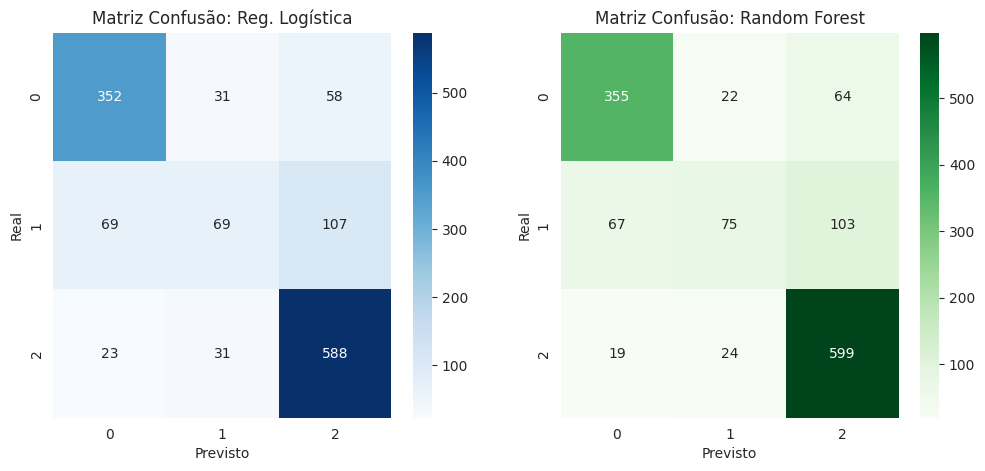

In [ ]:
# Função imprimir métricas
def print_metrics(model_name, y_true, y_pred):
    print(f"\n{model_name}")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.2%}")
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))


print_metrics("Regressão Logística", y_test, y_pred_log)
print_metrics("Random Forest ", y_test, y_pred_rf)

# Comparação Visual (Matrizes de Confusão)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Matriz Confusão: Reg. Logística')
ax[0].set_xlabel('Previsto'); ax[0].set_ylabel('Real')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Matriz Confusão: Random Forest')
ax[1].set_xlabel('Previsto'); ax[1].set_ylabel('Real')

plt.show()

### **Comparação Final**
Ao compararmos os resultados, o modelo Random Forest demonstrou desempenho superior à Regressão Logística em todas as métricas principais (Acurácia e F1-Score).

**Por que o Random Forest venceu?** A Regressão Logística é um modelo linear, o que limita sua capacidade de entender padrões complexos. Já o Random Forest, por ser um método de ensemble baseado em árvores de decisão, consegue capturar relações não-lineares entre as variáveis (ex: como a idade interage com as notas e o status financeiro de forma não direta).

**Ponto de Atenção:** Ambos os modelos tiveram maior dificuldade em classificar a classe "Enrolled" (Matriculado). Isso ocorre porque esta é uma classe de transição, onde as características dos alunos se misturam entre os que vão desistir e os que vão se formar, tornando a separação matemática mais difícil.

**Conclusão:** O Random Forest é o modelo mais indicado para este problema, pois sua robustez permitiu isolar melhor os fatores determinantes para o sucesso ou fracasso acadêmico, conforme evidenciado pela importância das variáveis de notas do 2º semestre.